In [1]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable
from sympy import Symbol, sin, cos, sec, tan, Matrix, integrate, eye, latex
import os
import cvxpy as cp
from linearizedcar import DubinsCar, dubinsCurve2d, Vertex
from scipy.integrate import solve_ivp

(CVXPY) Dec 13 06:31:31 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')


In [2]:
# system variables
rho = 1
length = 1
u_psi = 5
phi_max = np.pi/4

r_min = length / (np.tan(phi_max))

In [252]:
def nonlinearCar(q: np.ndarray, u: np.ndarray, t: float):
    return np.array([
        u[0] * rho * np.cos(q[2]), #x
        u[0] * rho * np.sin(q[2]), #y
        u[0] * rho / length * np.tan(q[4]), #theta
        u[0], #psi
        u[1], #phi
        u[2] #gamma
    ])

def aMat(t: float, qt: np.ndarray, ut: np.ndarray):
    A = np.zeros([6, 6])
    A[0, 2] = - ut[0] * rho * np.sin(qt[2])
    A[1, 2] = ut[0] * rho * np.cos(qt[2])
    A[2, 4] = ut[0] * rho / length * np.cos(qt[4]) ** -2
    return A

def bMat(t: float, qt: np.ndarray, ut: np.ndarray):
    B = np.zeros([6, 3])
    B[0, 0] = rho * np.cos(qt[2])
    B[1, 0] = rho * np.sin(qt[2])
    B[2, 0] = rho / length * np.tan(qt[4])
    B[3, 0] = 1
    B[4, 1] = 1
    B[5, 2] = 1
    return B

def linearizedCar(q: np.ndarray, u: np.ndarray, t: float, q_tilde: 'Callable[[float], np.ndarray]', u_tidle: 'Callable[[float], np.ndarray]'):
    qt = q_tilde(t)
    ut = u_tidle(t)
    f = nonlinearCar(qt, ut, t)
    A = aMat(t, qt, ut)
    B = bMat(t, qt, ut)
    return f + np.matmul(A, q - qt) + np.matmul(B, u - ut)



In [253]:
def straightLineGenerator(x0, y0, theta0, v):
    def f(t):
        return np.array([
            x0 + v * rho * np.cos(theta0) * t,
            y0 + v * rho * np.sin(theta0) * t,
            0,
            0,
            0,
            0
        ])
    return f

def curvePathGenerator(g, cost, theta_dot, phi, v):

    def f(t):
        xy = g(t / cost)
        xy_d = g(t / cost - .001)
        theta = np.arctan2(xy[1] - xy_d[1], xy[0] - xy_d[0])
        return np.array([
            xy[0],
            xy[1],
            theta,
            0,
            phi,
            0
        ])
    return f


In [254]:
def straightAmat(h, rho, length, u_psi, theta_0):
    return np.array([
        [1, 0, -u_psi * rho * np.sin(theta_0) * h, 0, 0, 0],
        [0, 1, u_psi * rho * np.cos(theta_0) * h, 0, 0, 0],
        [0, 0, 1, 0, u_psi * rho / length * h, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]
    ])

def straightBmat(h, rho, length, u_psi, theta_0):
    return np.array([
        [rho * np.cos(theta_0) * h, 0, 0],
        [rho * np.sin(theta_0) * h, 0, 0],
        [0, 0, 0],
        [h, 0, 0],
        [0, h, 0],
        [0, 0, h]
    ])

def straightDmat(h, rho, u_psi, theta_0):
    return np.array([
        rho * u_psi * np.cos(theta_0) * h,
        rho * u_psi * np.sin(theta_0) * h,
        0,
        u_psi * h,
        0,
        0
    ])

In [255]:
u_psi = Symbol('u_psi')
h = Symbol('h')
rho = Symbol('rho')
t = Symbol('t')
theta = Symbol('theta')
l = Symbol('l')
phi = Symbol('phi')

A = Matrix([
    [ 0, 0, -u_psi * rho * sin(theta), 0, 0, 0],
    [ 0, 0, u_psi * rho * cos(theta), 0, 0, 0],
    [ 0, 0, 0, 0,u_psi * rho / l * sec(phi) ** 2 , 0],
    [ 0, 0, 0, 0, 0, 0],
    [ 0, 0, 0, 0, 0, 0],
    [ 0, 0, 0, 0, 0, 0],
])
B = Matrix([
    [rho * cos(theta), 0, 0],
    [rho * sin(theta), 0, 0],
    [rho / l * tan(phi), 0, 0],
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])
A * A * A

Matrix([
[0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0]])

In [256]:
u_psi = Symbol('u_psi')
h = Symbol('h')
rho = Symbol('rho')
t = Symbol('t')
k = Symbol('k')
t_0 = Symbol('t_0')
theta_0 = Symbol('theta_0')
theta_dot = Symbol('thetadot', nonzero=True)
l = Symbol('l')
phi_c = Symbol('phi_c')

A = Matrix([
    [ 0, 0, -u_psi * rho * sin(theta_dot * t + theta_0), 0, 0, 0],
    [ 0, 0, u_psi * rho * cos(theta_dot * t + theta_0), 0, 0, 0],
    [ 0, 0, 0, 0,u_psi * rho / l * sec(phi_c) ** 2 , 0],
    [ 0, 0, 0, 0, 0, 0],
    [ 0, 0, 0, 0, 0, 0],
    [ 0, 0, 0, 0, 0, 0],
])
B = Matrix([
    [rho * cos(theta_dot * t + theta_0), 0, 0],
    [rho * sin(theta_dot * t + theta_0), 0, 0],
    [rho / l * tan(phi_c), 0, 0],
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

D = Matrix([
    rho * u_psi * cos(theta_dot * t + theta_0),
    rho * u_psi * sin(theta_dot * t + theta_0),
    rho / l * u_psi * tan(phi_c),
    u_psi,
    0,
    0
])
t_0 = 0
    

def Phi(r, tau):
    return eye(6) + integrate(A, (t, tau, r)) + integrate(A * integrate(A, (t, tau, t)), (t, tau , r))

F = Phi(h * (k+1) + t_0, k * h + t_0)
s = Symbol('s')
B = B.subs(t, s)
D = D.subs(t, s)
G = integrate(Phi(h * k + t_0, s) * B, (s, t_0 + h * k, h * (k+1) + t_0))
H = integrate(Phi(h * k + t_0, s) * D, (s, t_0 + h * k, h * (k+1) + t_0))

if not os.path.exists('target'):
    os.mkdir('target')

# with open('target/A[k].tex', 'w') as f:
#     f.write(latex(F.simplify()))

# with open('target/B[k].tex', 'w') as f:
#     f.write(latex(G.simplify()))

# with open('target/D[k].tex', 'w') as f:
#     f.write(latex(H.simplify()))



In [257]:
def curveAmat(h, rho, length, u_psi, theta_0, theta_dot, phi_c):
    def f(k):
        return np.array([
        [1, 0,
            rho * u_psi * ( -np.cos(h * k * theta_dot + theta_0) + np.cos(h * theta_dot * (k + 1) + theta_0)) / theta_dot, 0,
            rho ** 2 * u_psi ** 2 * (h * theta_dot * np.cos(h * theta_dot * (k + 1) + theta_0) + np.sin(h * k * h * theta_dot + theta_0) - np.sin(h * theta_dot * (k + 1) + theta_0)) / (np.cos(phi_c) ** 2 * length * theta_dot ** 2), 0],
        [1, 0,
            rho * u_psi * ( -np.sin(h * k * theta_dot + theta_0) + np.sin(h * theta_dot * (k + 1) + theta_0)) / theta_dot, 0,
            rho ** 2 * u_psi ** 2 * (h * theta_dot * np.sin(h * theta_dot * (k + 1) + theta_0) - np.cos(h * k * h * theta_dot + theta_0) + np.cos(h * theta_dot * (k + 1) + theta_0)) / (np.cos(phi_c) ** 2 * length * theta_dot ** 2), 0],
        [0, 0, 1, 0, h * u_psi * rho / (np.cos(phi_c) ** 2 * length), 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]
        ])
    return f

def curveBmat(h, rho, length, u_psi, theta_0, theta_dot, phi_c):
    def f(k):
        return np.array([
            [rho * (length * theta_dot * (-np.sin(h * k * theta_dot + theta_0) + np.sin(h * theta_dot * (k + 1) + theta_0)) + rho * u_psi * (h * theta_dot * np.cos(h * k * theta_dot + theta_0) + np.sin(h * k * theta_dot + theta_0) - np.sin(h * theta_dot * (k + 1) + theta_0)) * np.tan(phi_c)) / (length * theta_dot ** 2),
            rho ** 2 * u_psi ** 2 * (-.5 * h ** 2 * theta_dot ** 2 * np.cos(h * k * theta_dot + theta_0) - h * theta_dot * np.sin(h * k * theta_dot + theta_0) + np.cos(h * k * theta_dot + theta_0) - np.cos(h * theta_dot * (k + 1) + theta_0)) / (length * theta_dot ** 3 * np.cos(phi_c) ** 2), 0],
            [rho * (length * theta_dot * (np.cos(h * k * theta_dot + theta_0) - np.cos(h * theta_dot * (k + 1) + theta_0)) + rho * u_psi * (h * theta_dot * np.sin(h * k * theta_dot + theta_0) - np.cos(h * k * theta_dot + theta_0) + np.cos(h * theta_dot * (k + 1) + theta_0)) * np.tan(phi_c)) / (length * theta_dot ** 2),
            rho ** 2 * u_psi ** 2 * (-.5 * h ** 2 * theta_dot ** 2 * np.sin(h * k * theta_dot + theta_0) + h * theta_dot * np.cos(h * k * theta_dot + theta_0) + np.sin(h * k * theta_dot + theta_0) - np.sin(h * theta_dot * (k + 1) + theta_0)) / (length * theta_dot ** 3 * np.cos(phi_c) ** 2), 0],
            [h * rho * np.tan(phi_c) / length, h ** 2 * rho * u_psi /(2 * length * np.cos(phi_c) ** 2), 0],
            [h, 0, 0],
            [0, h, 0],
            [0, 0, h]
        ])
    return f

def curveDmat(h, rho, length, u_psi, theta_0, theta_dot, phi_c):
    def f(k):
        return np.array([
            rho * u_psi * (length * theta_dot * (-np.sin(h * k * theta_dot + theta_0) + np.sin(h * theta_dot * (k + 1) + theta_0)) + rho * u_psi * (h * ( theta_dot * np.cos(h * k * theta_dot + theta_0) + np.sin(h * k * theta_dot + theta_0) - np.sin(h * theta_dot * (k + 1) + theta_0)) * np.tan(phi_c))) / (length * theta_dot ** 2),
            rho * u_psi * (length * theta_dot * (np.cos(h * k * theta_dot + theta_0) - np.cos(h * theta_dot * (k + 1) + theta_0)) + rho * u_psi * (h * ( theta_dot * np.sin(h * k * theta_dot + theta_0) - np.cos(h * k * theta_dot + theta_0) + np.cos(h * theta_dot * (k + 1) + theta_0)) * np.tan(phi_c))) / (length * theta_dot ** 2),
            h * rho * u_psi * np.tan(phi_c) / length,
            u_psi * h,
            0,
            0
        ])
    return f

c:\Users\chagu\repos\LinearizedCarRobot\linearizedcar\dubinsCar.py:164: RuntimeWarning: invalid value encountered in sqrt
  b = np.sqrt((x + m_sth) * (x + m_sth) + (y - m_cth - 1) * (y - m_cth - 1) - 4)


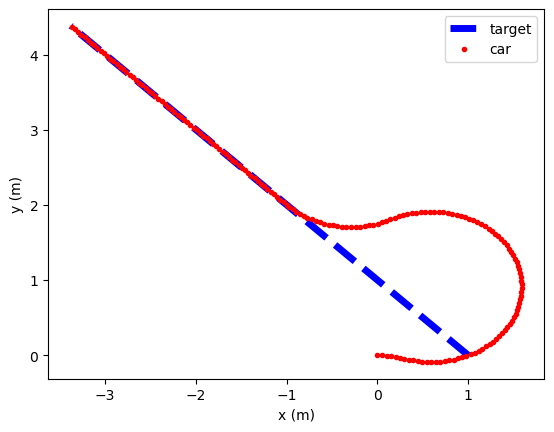

In [258]:
dt = .05
r = 1
v_t = .7

# target dynamics
# x[k+1] = I x[k] + dt u
u_t = np.array([-1.0, 1.0, 0])
u_t /= np.linalg.norm(u_t) 
u_t *= v_t


T = 177
x_t = np.zeros([3, T + 1])
x_t[:, 0] = [1, 0, 1]
for k in range(T):
    x_t[:, k + 1] = x_t[:, k] + dt * u_t

fig = plt.figure()
ax = fig.gca()
ax.plot(x_t[0, :], x_t[1, :], ls='--', c='b', lw='5')

planner = DubinsCar()
# car start
totalcost = 0
start = Vertex(x=0, y=0, psi=0)
end = Vertex(x=-1, y=2, psi=3/4 * np.pi)
path0 = planner.calculatePath(start, end, r)
final = Vertex(x=x_t[0, -1], y=x_t[1, -1], psi=3/4 * np.pi)
path1 = planner.calculatePath(end, final, r)

t_steps = np.arange(0, T) * dt

f = dubinsCurve2d(path0.start.toarray(), path0.a, path0.b, path0.c, path0.r, path0.type)
S0 = t_steps[t_steps < path0.cost]
S0 = S0 / path0.cost
S1 = t_steps[t_steps > path0.cost]
S1 = (S1 - S1[0]) / path1.cost
T_c = len(S0)
T_s = len(S1)

p = np.array([f(s) for s in S0])
ax.plot(p[:, 0], p[:, 1], 'r.')

f = dubinsCurve2d(path1.start.toarray(), path1.a, path1.b, path1.c, path1.r, path1.type)
# S = S[:(T - T_c)]
w = np.array([f(s) for s in S1])
ax.plot(w[:, 0], w[:, 1], 'r.')

ax.legend(['target', 'car'])
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
fig.savefig('target/trajectories.pdf')
xy_des = np.row_stack([p, w])

In [259]:
# build A matrices
A = np.zeros([6, 6, T])
B = np.zeros([6, 3, T])
D = np.zeros([6, T])
phi_tilde = np.zeros([T])
length = 1
rho = .05
u_psi = 1 / rho

T_1 = int(np.floor(path0.a / path0.cost * T_c))
k = 0
# first curve
a = curveAmat(dt, rho, length, u_psi, 0, -rho * u_psi / r, -phi_max)
b = curveBmat(dt, rho, length, u_psi, 0, -rho * u_psi / r, -phi_max)
d = curveDmat(dt, rho, length, u_psi, 0, -rho * u_psi / r, -phi_max)
for i in range(T_1):
    A[:, :, k] = a(i)
    B[:, :, k] = b(i)
    D[:, k] = d(i)
    phi_tilde[k] = -phi_max
    k += 1
# second curve
theta_0 = -path0.a / r
T_2 = int(np.floor(path0.b / path0.cost * T_c))
a = curveAmat(dt, rho, length, u_psi, theta_0, rho * u_psi / r, phi_max)
b = curveBmat(dt, rho, length, u_psi, theta_0, rho * u_psi / r, phi_max)
d = curveDmat(dt, rho, length, u_psi, theta_0, rho * u_psi / r, phi_max)
for i in range(T_2):
    A[:, :, k] = a(i)
    B[:, :, k] = b(i)
    D[:, k] = d(i)
    phi_tilde[k] = phi_max
    k += 1

# thrid curve
theta_0 += path0.b / r
T_3 = T_c - T_2 - T_1
a = curveAmat(dt, rho, length, u_psi, theta_0, -rho * u_psi / r, -phi_max)
b = curveBmat(dt, rho, length, u_psi, theta_0, -rho * u_psi / r, -phi_max)
d = curveDmat(dt, rho, length, u_psi, theta_0, -rho * u_psi / r, -phi_max)
for i in range(T_3):
    A[:, :, k] = a(i)
    B[:, :, k] = b(i)
    D[:, k] = d(i)
    phi_tilde[k] = -phi_max
    k += 1

theta_0 += -path0.c / r
T_4 = T_s
a = straightAmat(dt, rho, length, u_psi, theta_0)
b = straightBmat(dt, rho, length, u_psi, theta_0)
d = straightDmat(dt, rho, u_psi, theta_0)
for i in range(T_4):
    A[:, :, k] = a
    B[:, :, k] = b
    D[:, k] = d
    phi_tilde[k] = 0
    k += 1

In [260]:
Q = np.eye(6)
R = np.eye(6)

q = cp.Variable((6, T + 1))
u = cp.Variable((3, T))
alpha = .001
beta = 100
cost = 0
constr = []
for k in range(T):
    cost += cp.sum_squares(q[:, k]) + alpha * cp.sum_squares(u[:, k])
    constr += [
        q[:, k + 1] == A[:, :, k] @ q[:, k] + B[:, :, k] @ u[:, k] + D[:, k],
        q[4] >= -phi_max - phi_tilde[k],
        q[4] <= phi_max - phi_tilde[k],
        u[0] >= 0,
        u[0] <= u_psi,
        # cp.abs(u[2]) <= 1
    ]
cost += beta * T * cp.sum_squares(q[:, T])
constr += [q[:, 0] == np.array([0, 0, 0, 0, 0, 0])]

problem = cp.Problem(cp.Minimize(cost), constr)
problem.solve()

c:\Users\chagu\.conda\envs\controls\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


560606132.2751137

(-1.0, 1.0)

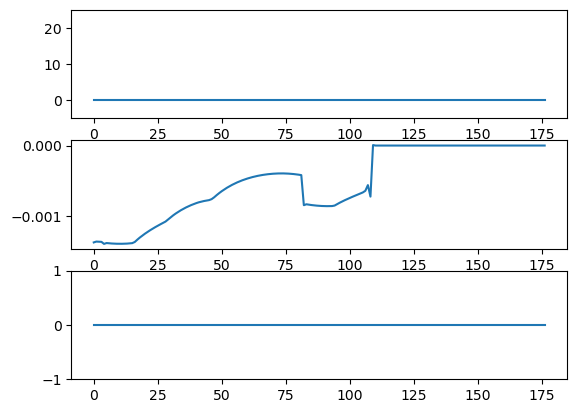

In [261]:
fig = plt.figure()
axes = fig.subplots(3, 1)
axes[0].plot(u[0, :].value)
axes[0].set_ylim([-5, 25])
axes[1].plot(u[1, :].value)
# axes[1].set_ylim([-1, 1])
axes[2].plot(u[2, :].value)
axes[2].set_ylim([-1, 1])

<AxesSubplot:>

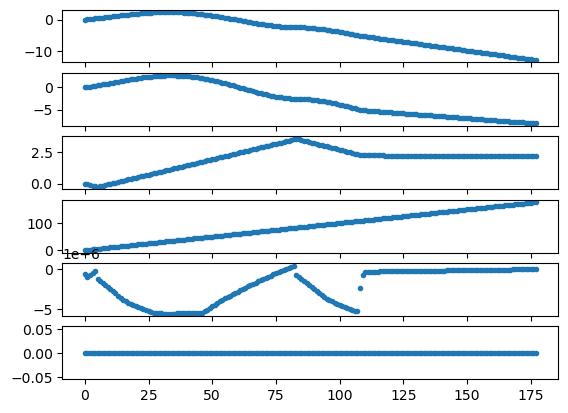

In [262]:
fig = plt.figure()
axes = fig.subplots(6, 1)
axes[0].plot(q[0, :].value, '.')
axes[1].plot(q[1, :].value, '.')
axes[2].plot(q[2, :].value, '.')
axes[3].plot(q[3, :].value, '.')
axes[4].plot(q[4, :].value, '.')
axes[5].plot(q[5, :].value, '.')

axes[4]

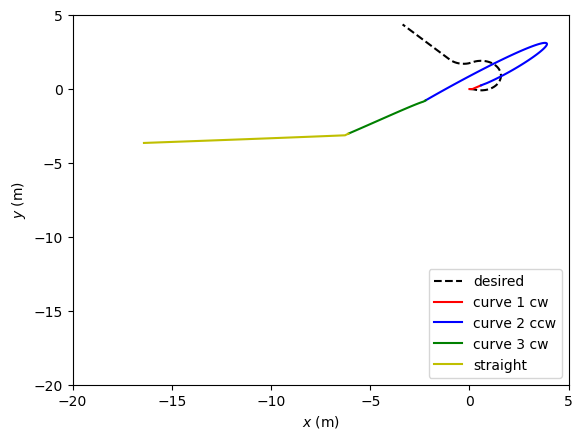

In [263]:
x_desired = []

# first path
f = dubinsCurve2d(path0.start.toarray(), path0.a, path0.b, path0.c, r, path0.type)
t = np.arange(0, path0.cost, dt)
t /= path0.cost
x_r = np.zeros([6, T + 1])
# first curve
k = 0
g = curvePathGenerator(f, path0.cost, -1, -phi_max, u_psi)
for i in range(T_1):
    x_r[:, k] = q[:, k].value + g(k * dt)
    x_desired.append(g(k * dt))
    k += 1
    
# second curve
xy = f(t[k])
alt = f(t[k] - .001)
theta = np.arctan2(xy[1] - alt[1], xy[0] - alt[0])
g = curvePathGenerator(f, path0.cost, 1, phi_max, u_psi)
for i in range(T_2):
    x_r[:, k] = q[:, k].value + g(k * dt)
    x_desired.append(g(k * dt))
    k += 1

# thrid curve
xy = f(t[k])
alt = f(t[k] - .001)
theta = np.arctan2(xy[1] - alt[1], xy[0] - alt[0])
g = curvePathGenerator(f, path0.cost, -1, -phi_max, u_psi)
for i in range(T_3):
    x_r[:, k] = q[:, k].value + g(k * dt)
    x_desired.append(g(k * dt))
    k += 1

# second path
g = straightLineGenerator(path1.start.x, path1.start.y, path1.start.psi, u_psi)
for i in range(T_4 + 1):
    x_r[:, k] = q[:, k].value + g(i * dt)
    x_desired.append(g(i * dt))
    k += 1

x_desired = np.array(x_desired)
x_desired[:, 3] = np.arange(T + 1) * dt * u_psi

fig = plt.figure()
ax = fig.gca()
ax.plot(xy_des[:, 0], xy_des[:, 1], c='k', ls='--', label='desired')
ax.plot(x_r[0, :T_1], x_r[1, :T_1], c='r', label='curve 1 cw')
ax.plot(x_r[0,(T_1 - 1):(T_1 + T_2)], x_r[1, (T_1 - 1):(T_1 + T_2)], c='b', label='curve 2 ccw')
ax.plot(x_r[0, (T_1 + T_2 - 1):T_c], x_r[1, (T_1 + T_2 - 1):T_c], c='g', label='curve 3 cw')
ax.plot(x_r[0, (T_c - 1):], x_r[1, (T_c - 1):], c='y', label='straight')
x_r[0, T_2:T_3]
ax.set_xlim([-20, 5])
ax.set_ylim([-20, 5])
ax.set_ylabel('$y$ (m)')
ax.set_xlabel('$x$ (m)')
ax.legend(loc=4)
fig.savefig('target/xyplane.pdf')

In [264]:
u_trajectory = np.repeat([[u_psi, 0 , 0]], repeats=T, axis=0).T
u_r = u.value.copy() + u_trajectory

In [265]:
heading = np.column_stack([np.cos(x_r[2, :]), np.sin(x_r[2, :])]).T
dist = x_t[:2, :] - x_r[:2, :]
direction = np.einsum('ij, ij->j', heading, dist)
direction = direction / np.abs(direction)
signedDistance = np.linalg.norm(dist, axis=0) * direction
g_des = np.arctan2(x_t[2, :], signedDistance)
x_desired[:, 5] = g_des


In [266]:
# first order linear feedback loop for gamma
# u_\gamma = -k \gamma
# \gamma[n+1] = (1 - kh) \gamma[n] + kh\tilde{\gamma}[n]
k_f = 10

for n in range(T):
    x_r[5, n + 1] = (1 - k_f * dt) * x_r[5, n] + k_f * dt * x_desired[n, 5]
    u_r[2, n] = -k_f * (x_r[5, n] - x_desired[n, 5])

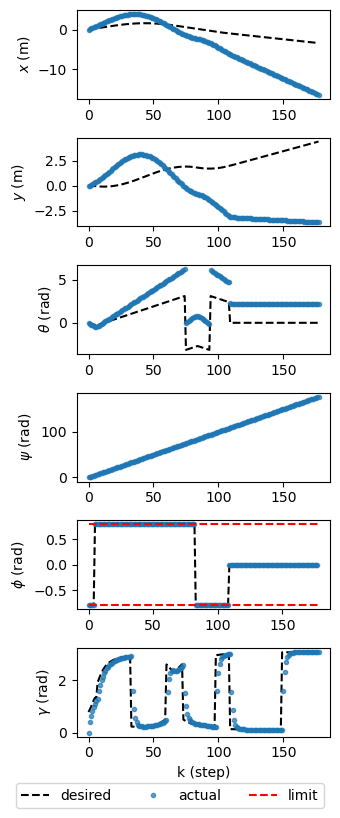

In [267]:
fig = plt.figure(figsize=(3.5, 8))
axes = fig.subplots(6, 1)
p1 = axes[0].plot(x_desired[:, 0], 'k--', label='desired')
p2 = axes[0].plot(x_r[0, :], '.', alpha=.7, label='actual')
axes[0].set_ylabel('$x$ (m)')
axes[1].plot(x_desired[:, 1], 'k--')
axes[1].plot(x_r[1, :], '.', alpha=.7)
axes[1].set_ylabel('$y$ (m)')
axes[2].plot(x_desired[:, 2], 'k--')
axes[2].plot(x_r[2, :], '.', alpha=.7)
axes[2].set_ylabel(r'$\theta$ (rad)')
axes[3].plot(x_desired[:, 3], 'k--')
axes[3].plot(x_r[3, :], '.', alpha=.7)
axes[3].set_ylabel('$\psi$ (rad)')
axes[4].plot(x_desired[:, 4], 'k--')
axes[4].plot(x_r[4, :], '.', alpha=.7)
axes[4].set_ylabel('$\phi$ (rad)')
p3 = axes[4].plot([0, T+1], [-phi_max, -phi_max], c='r', ls='--', label='limit')
axes[4].plot([0, T+1], [phi_max, phi_max], c='r', ls='--')
axes[5].plot(x_desired[:, 5], 'k--')
axes[5].plot(x_r[5, :], '.', alpha=.7)
axes[5].set_ylabel('$\gamma$ (rad)')
axes[5].set_xlabel('k (step)')
fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(.5, -.025))
fig.tight_layout()
fig.savefig('target/path.pdf', bbox_inches='tight')

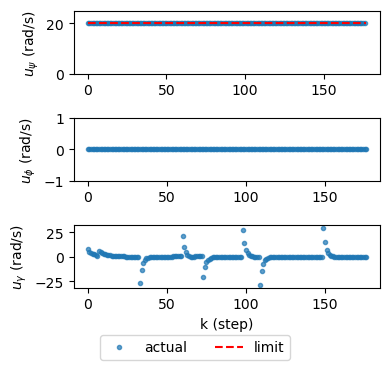

In [268]:
fig = plt.figure(figsize=(4, 3.5))
axes = fig.subplots(3, 1)
axes[0].plot(u_r[0, :], '.', alpha=.7)
axes[0].plot([0, len(u_r[0, :])], [20, 20], c='r', ls='--')
axes[0].set_ylim([0, 25])
axes[0].set_ylabel(r'$u_\psi$ (rad/s)')
axes[1].plot(u_r[1, :], '.', alpha=.7)
axes[1].set_ylim([-1, 1])
axes[1].set_ylabel(r'$u_\phi$ (rad/s)')
axes[2].plot(u_r[2, :], '.', alpha=.7)
axes[2].set_ylabel(r'$u_\gamma$ (rad/s)')
axes[2].set_xlabel('k (step)')
fig.legend(['actual', 'limit'], loc='lower center', ncol=3, bbox_to_anchor=(.5, -.06))

fig.tight_layout()
fig.savefig('target/controller.pdf', bbox_inches='tight')

In [269]:
def control(t):
   k = int(np.floor(t / dt))
   if k >= u_r.shape[1]:
      return np.array([0, 0, 0])
   return u_r[:, k]


def sys(t, x):
   u = control(t)
   return nonlinearCar(x, u, t)
nonlin = solve_ivp(sys, [0, T * dt], [0, 0, 0, 0, -phi_max, 0], max_step=.1) 

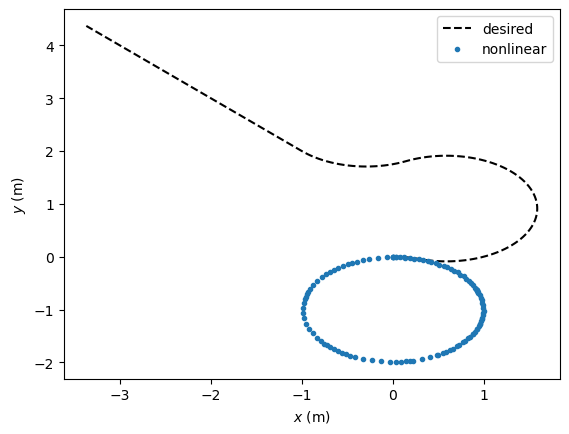

In [270]:

fig = plt.figure()
ax = fig.gca()
ax.plot(xy_des[:, 0], xy_des[:, 1], c='k', ls='--', label='desired')

ax.plot(nonlin.y[0, :], nonlin.y[1, :], '.', label='nonlinear')
ax.legend()
ax.set_ylabel('$y$ (m)')
ax.set_xlabel('$x$ (m)')
fig.savefig('target/nonlinearxy.pdf')

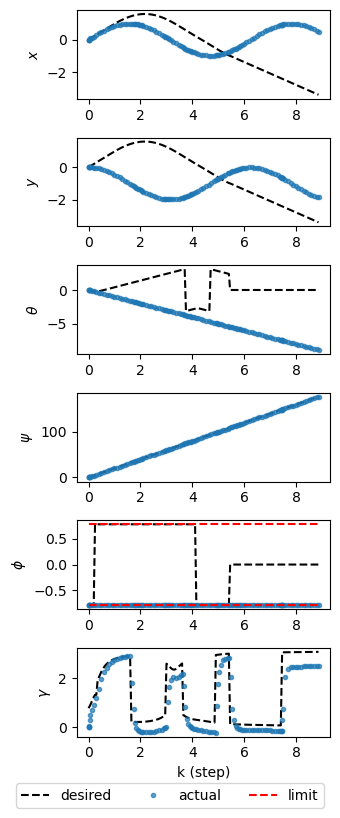

In [271]:
fig = plt.figure(figsize=(3.5, 8))
axes = fig.subplots(6, 1)
t_step = np.arange(T + 1) * dt
axes[0].plot(t_step, x_desired[:, 0], 'k--', label='desired')
axes[0].plot(nonlin.t, nonlin.y[0, :], '.', alpha=.7, label='actual')
axes[0].set_ylabel('$x$')
axes[1].plot(t_step, x_desired[:, 0], 'k--')
axes[1].plot(nonlin.t, nonlin.y[1, :], '.', alpha=.7)
axes[1].set_ylabel('$y$')
axes[2].plot(t_step, x_desired[:, 2], 'k--')
axes[2].plot(nonlin.t, nonlin.y[2, :], '.', alpha=.7)
axes[2].set_ylabel(r'$\theta$')
axes[3].plot(t_step, x_desired[:, 3], 'k--')
axes[3].plot(nonlin.t, nonlin.y[3, :], '.', alpha=.7)
axes[3].set_ylabel('$\psi$')
axes[4].plot(t_step, x_desired[:, 4], 'k--')
axes[4].plot(nonlin.t, nonlin.y[4, :], '.', alpha=.7)
axes[4].set_ylabel('$\phi$')
axes[4].plot([0, t_step[-1]], [-phi_max, -phi_max], c='r', ls='--', label='limit')
axes[4].plot([0, t_step[-1]], [phi_max, phi_max], c='r', ls='--')
axes[5].plot(t_step, x_desired[:, 5], 'k--')
axes[5].plot(nonlin.t, nonlin.y[5, :], '.', alpha=.7)
axes[5].set_ylabel('$\gamma$')
axes[5].set_xlabel('k (step)')
fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(.5, -.025))
fig.tight_layout()
fig.savefig('target/nonlinearpath.pdf', bbox_inches='tight')